In [ ]:
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np

#libreria para el manejo de dataframes
import pandas as pd

# Libreria para dar valores a texto
from sklearn.preprocessing import LabelEncoder

# Librerias para graficar
from matplotlib import pyplot

# Modulo de optimización de scipy
from scipy import optimize

from sklearn.preprocessing import OneHotEncoder

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

In [ ]:
# Cargar datos
datos = pd.read_excel('/content/elecciones 2025.xlsx')
datos.columns = datos.columns.str.strip()

# Limpiar espacios en columnas de texto
text_columns = ["NombrePais", "NombreDepartamento", "NombreProvincia"]
for col in text_columns:
    datos[col] = datos[col].str.strip()

# Lista de columnas de votos (partidos y votos especiales)
votos_cols = [
    "AP", "LYP ADN", "APB SUMATE", "LIBRE", "FP",
    "MAS-IPSP", "MORENA", "UNIDAD", "PDC",
    "VotoBlanco", "VotoNuloDirecto", "VotoNuloDeclinacion"
]

# ===============================
# Construcción de X (features)
# ===============================

# Ejemplo: usamos inscritos + todos los votos de cada partido/nulos/blancos
# Creamos un LabelEncoder por cada columna
le_pais = LabelEncoder()
le_depto = LabelEncoder()
le_prov = LabelEncoder()

datos["Pais"] = le_pais.fit_transform(datos["NombrePais"])
datos["Departamento"] = le_depto.fit_transform(datos["NombreDepartamento"])
datos["Provincia"] = le_prov.fit_transform(datos["NombreProvincia"])

X = datos[["Pais", "Departamento", "Provincia", "InscritosHabilitados"]].values

# ===============================
# Construcción de Y (target)
# ===============================

# Para cada fila, verificamos si AP tiene más votos que todos los demás
datos["Ganador"] = (datos["PDC"] == datos[votos_cols].max(axis=1)).astype(int)

Y = datos["Ganador"].values

# ===============================
# Verificación
# ===============================
print("Shape de X:", X.shape)

print("Ejemplos de X (10 filas):")
print(X[:10])

print("\nEjemplos de Y (10 etiquetas):")
print(Y[:10])


Shape de X: (69279, 4)
Ejemplos de X (10 filas):
[[  0   6  23 264]
 [  1   8  30 320]
 [  1   8  30 320]
 [  1   8  30 320]
 [  1   8  30 320]
 [  1   8  30 320]
 [  1   8  30 320]
 [  1   8  30 320]
 [  1   8  30 320]
 [  1   8  30 320]]

Ejemplos de Y (10 etiquetas):
[0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Función de Normalización CORREGIDA (por características)
def normalizar(X):
    min_vals = np.min(X, axis=0)  # mínimo por columna
    max_vals = np.max(X, axis=0)  # máximo por columna
    # Evitar división por cero
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # si max == min, range = 1
    return (X - min_vals) / range_vals, min_vals, max_vals

In [ ]:
# Funcion Sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
# Normalizar X (guardando parámetros para predicción)
X_normalized, X_min, X_max = normalizar(X)

In [ ]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al término de intercepción
m, n = X.shape
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [ ]:
# Funcion de costo
def calcularCosto(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    return J

In [ ]:
# Descenso por gradiente
def descensoGradiente(theta, X, y, alpha, num_iters):
    m = y.shape[0]
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (X.T.dot(h - y)).T
        J_history.append(calcularCosto(theta, X, y))

    return theta, J_history

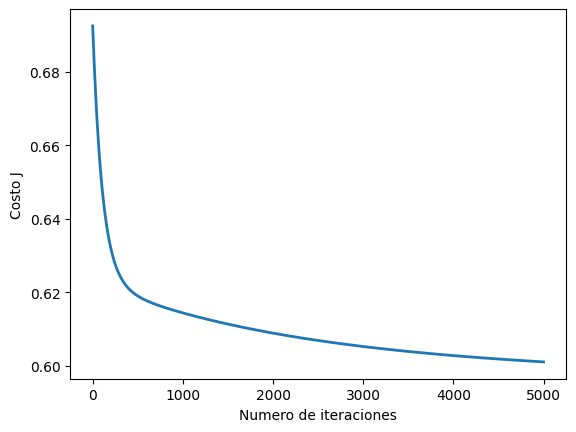

theta calculado por el descenso por el gradiente: [-0.71078947 -0.08323563 -0.45619225  0.74092908 -0.23293697]


In [ ]:
# Parámetros
alpha = 0.01
num_iters = 5000
 # inicializa con el tamaño correcto

# Agregar columna de bias
X_with_bias = np.insert(X_normalized, 0, 1, axis=1)

theta = np.zeros(X_with_bias.shape[1])

# Ejecutar descenso
theta, J_history = descensoGradiente(theta, X_with_bias, Y, alpha, num_iters)

# Graficar costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')
pyplot.show()

# Mostrar theta
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

In [ ]:
# ===============================
# PREDICCIÓN PARA NUEVO DATO
# ===============================

nuevo_pais = "BOLIVIA"
nuevo_depto = "La Paz"
nueva_prov = "Murillo"
inscritos = 4020

# Transformar categorías
pais_enc = le_pais.transform([nuevo_pais])[0]
depto_enc = le_depto.transform([nuevo_depto])[0]
prov_enc = le_prov.transform([nueva_prov])[0]

# Crear array con el MISMO orden
X_nuevo = np.array([pais_enc, depto_enc, prov_enc, inscritos])

# Normalizar usando los MISMOS parámetros
X_nuevo_normalized = (X_nuevo - X_min) / (X_max - X_min)

# Agregar bias
X_nuevo_con_bias = np.insert(X_nuevo_normalized, 0, 1)

# Predicción
prob = sigmoid(np.dot(X_nuevo_con_bias, theta))
pred = int(prob >= 0.5)

print(f"Probabilidad de ganar: {prob:.4f}")
print(f"Predicción final (0=pierde, 1=gana): {pred}")

Probabilidad de ganar: 0.0369
Predicción final (0=pierde, 1=gana): 0
